In [1]:

import theano.tensor as T
import theano
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random
import time

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print( 'iter ' + str(iter+1)) 
            
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta

In [3]:
class svgd_bayesnn:

    '''
        We define a one-hidden-layer-neural-network specifically. We leave extension of deep neural network as our future work.
        
        Input
            -- X_train: training dataset, features
            -- y_train: training labels
            -- batch_size: sub-sampling batch size
            -- max_iter: maximum iterations for the training procedure
            -- M: number of particles are used to fit the posterior distribution
            -- n_hidden: number of hidden units
            -- a0, b0: hyper-parameters of Gamma distribution
            -- master_stepsize, auto_corr: parameters of adgrad
    '''
    def __init__(self, X_train, y_train,  batch_size = 100, max_iter = 1000, M = 20, n_hidden = 50, a0 = 1, b0 = 0.1, master_stepsize = 1e-3, auto_corr = 0.9):
        self.n_hidden = n_hidden
        self.d = X_train.shape[1]   # number of data, dimension 
        self.M = M
        
        num_vars = self.d * n_hidden + n_hidden * 2 + 3  # w1: d*n_hidden; b1: n_hidden; w2 = n_hidden; b2 = 1; 2 variances
        self.theta = np.zeros([self.M, num_vars])  # particles, will be initialized later
        
        '''
            We keep the last 10% (maximum 500) of training data points for model developing
        '''
        size_dev = min(int(np.round(0.1 * X_train.shape[0])), 500)
        X_dev, y_dev = X_train[-size_dev:], y_train[-size_dev:]
        X_train, y_train = X_train[:-size_dev], y_train[:-size_dev]

        '''
            The data sets are normalized so that the input features and the targets have zero mean and unit variance
        '''
        self.std_X_train = np.std(X_train, 0)
        self.std_X_train[ self.std_X_train == 0 ] = 1
        self.mean_X_train = np.mean(X_train, 0)
                
        self.mean_y_train = np.mean(y_train)
        self.std_y_train = np.std(y_train)
        
        '''
            Theano symbolic variables
            Define the neural network here
        '''
        X = T.matrix('X') # Feature matrix
        y = T.vector('y') # labels
        
        w_1 = T.matrix('w_1') # weights between input layer and hidden layer
        b_1 = T.vector('b_1') # bias vector of hidden layer
        w_2 = T.vector('w_2') # weights between hidden layer and output layer
        b_2 = T.scalar('b_2') # bias of output
        
        N = T.scalar('N') # number of observations
        
        log_gamma = T.scalar('log_gamma')   # variances related parameters
        log_lambda = T.scalar('log_lambda')
        
        ###
        prediction = T.dot(T.nnet.relu(T.dot(X, w_1)+b_1), w_2) + b_2
        
        ''' define the log posterior distribution '''
        log_lik_data = -0.5 * X.shape[0] * (T.log(2*np.pi) - log_gamma) - (T.exp(log_gamma)/2) * T.sum(T.power(prediction - y, 2))
        log_prior_data = (a0 - 1) * log_gamma - b0 * T.exp(log_gamma) + log_gamma
        log_prior_w = -0.5 * (num_vars-2) * (T.log(2*np.pi)-log_lambda) - (T.exp(log_lambda)/2)*((w_1**2).sum() + (w_2**2).sum() + (b_1**2).sum() + b_2**2)  \
                       + (a0-1) * log_lambda - b0 * T.exp(log_lambda) + log_lambda
        
        # sub-sampling mini-batches of data, where (X, y) is the batch data, and N is the number of whole observations
        log_posterior = (log_lik_data * N / X.shape[0] + log_prior_data + log_prior_w)
        dw_1, db_1, dw_2, db_2, d_log_gamma, d_log_lambda = T.grad(log_posterior, [w_1, b_1, w_2, b_2, log_gamma, log_lambda])
        
        # automatic gradient
        logp_gradient = theano.function(
             inputs = [X, y, w_1, b_1, w_2, b_2, log_gamma, log_lambda, N],
             outputs = [dw_1, db_1, dw_2, db_2, d_log_gamma, d_log_lambda]
        )
        
        # prediction function
        self.nn_predict = theano.function(inputs = [X, w_1, b_1, w_2, b_2], outputs = prediction)
        
        '''
            Training with SVGD
        '''
        # normalization
        X_train, y_train = self.normalization(X_train, y_train)
        N0 = X_train.shape[0]  # number of observations
        
        ''' initializing all particles '''
        for i in range(self.M):
            w1, b1, w2, b2, loggamma, loglambda = self.init_weights(a0, b0)
            # use better initialization for gamma
            ridx = np.random.choice(range(X_train.shape[0]), \
                                           np.min([X_train.shape[0], 1000]), replace = False)
            y_hat = self.nn_predict(X_train[ridx,:], w1, b1, w2, b2)
            loggamma = -np.log(np.mean(np.power(y_hat - y_train[ridx], 2)))
            self.theta[i,:] = self.pack_weights(w1, b1, w2, b2, loggamma, loglambda)

        grad_theta = np.zeros([self.M, num_vars])  # gradient 
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(max_iter):
            # sub-sampling
            batch = [ i % N0 for i in range(iter * batch_size, (iter + 1) * batch_size) ]
            for i in range(self.M):
                w1, b1, w2, b2, loggamma, loglambda = self.unpack_weights(self.theta[i,:])
                dw1, db1, dw2, db2, dloggamma, dloglambda = logp_gradient(X_train[batch,:], y_train[batch], w1, b1, w2, b2, loggamma, loglambda, N0)
                grad_theta[i,:] = self.pack_weights(dw1, db1, dw2, db2, dloggamma, dloglambda)
                
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(h=-1)  
            grad_theta = (np.matmul(kxy, grad_theta) + dxkxy) / self.M   # \Phi(x)
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + np.multiply(grad_theta, grad_theta)
            else:
                historical_grad = auto_corr * historical_grad + (1 - auto_corr) * np.multiply(grad_theta, grad_theta)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            self.theta = self.theta + master_stepsize * adj_grad 

        '''
            Model selection by using a development set
        '''
        X_dev = self.normalization(X_dev) 
        for i in range(self.M):
            w1, b1, w2, b2, loggamma, loglambda = self.unpack_weights(self.theta[i, :])
            pred_y_dev = self.nn_predict(X_dev, w1, b1, w2, b2) * self.std_y_train + self.mean_y_train
            # likelihood
            def f_log_lik(loggamma): return np.sum(  np.log(np.sqrt(np.exp(loggamma)) /np.sqrt(2*np.pi) * np.exp( -1 * (np.power(pred_y_dev - y_dev, 2) / 2) * np.exp(loggamma) )) )
            # The higher probability is better    
            lik1 = f_log_lik(loggamma)
            # one heuristic setting
            loggamma = -np.log(np.mean(np.power(pred_y_dev - y_dev, 2)))
            lik2 = f_log_lik(loggamma)
            if lik2 > lik1:
                self.theta[i,-2] = loggamma  # update loggamma


    def normalization(self, X, y = None):
        X = (X - np.full(X.shape, self.mean_X_train)) / \
            np.full(X.shape, self.std_X_train)
            
        if y is not None:
            y = (y - self.mean_y_train) / self.std_y_train
            return (X, y)  
        else:
            return X
    
    '''
        Initialize all particles
    '''
    def init_weights(self, a0, b0):
        w1 = 1.0 / np.sqrt(self.d + 1) * np.random.randn(self.d, self.n_hidden)
        b1 = np.zeros((self.n_hidden,))
        w2 = 1.0 / np.sqrt(self.n_hidden + 1) * np.random.randn(self.n_hidden)
        b2 = 0.
        loggamma = np.log(np.random.gamma(a0, b0))
        loglambda = np.log(np.random.gamma(a0, b0))
        return (w1, b1, w2, b2, loggamma, loglambda)
    
    '''
        Calculate kernel matrix and its gradient: K, \nabla_x k
    ''' 
    def svgd_kernel(self, h = -1):
        sq_dist = pdist(self.theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(self.theta.shape[0]+1))

        # compute the rbf kernel
        
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, self.theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(self.theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(self.theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    
    '''
        Pack all parameters in our model
    '''    
    def pack_weights(self, w1, b1, w2, b2, loggamma, loglambda):
        params = np.concatenate([w1.flatten(), b1, w2, [b2], [loggamma],[loglambda]])
        return params
    
    '''
        Unpack all parameters in our model
    '''
    def unpack_weights(self, z):
        w = z
        w1 = np.reshape(w[:self.d*self.n_hidden], [self.d, self.n_hidden])
        b1 = w[self.d*self.n_hidden:(self.d+1)*self.n_hidden]
    
        w = w[(self.d+1)*self.n_hidden:]
        w2, b2 = w[:self.n_hidden], w[-3] 
        
        # the last two parameters are log variance
        loggamma, loglambda= w[-2], w[-1]
        
        return (w1, b1, w2, b2, loggamma, loglambda)

    
    '''
        Evaluating testing rmse and log-likelihood, which is the same as in PBP 
        Input:
            -- X_test: unnormalized testing feature set
            -- y_test: unnormalized testing labels
    '''
    def evaluation(self, X_test, y_test):
        # normalization
        X_test = self.normalization(X_test)
        
        # average over the output
        pred_y_test = np.zeros([self.M, len(y_test)])
        prob = np.zeros([self.M, len(y_test)])
        
        '''
            Since we have M particles, we use a Bayesian view to calculate rmse and log-likelihood
        '''
        for i in range(self.M):
            w1, b1, w2, b2, loggamma, loglambda = self.unpack_weights(self.theta[i, :])
            pred_y_test[i, :] = self.nn_predict(X_test, w1, b1, w2, b2) * self.std_y_train + self.mean_y_train
            prob[i, :] = np.sqrt(np.exp(loggamma)) /np.sqrt(2*np.pi) * np.exp( -1 * (np.power(pred_y_test[i, :] - y_test, 2) / 2) * np.exp(loggamma) )
        pred = np.mean(pred_y_test, axis=0)
        
        # evaluation
        svgd_rmse = np.sqrt(np.mean((pred - y_test)**2))
        svgd_ll = np.mean(np.log(np.mean(prob, axis = 0)))
        
        return (svgd_rmse, svgd_ll)

In [4]:
def prepDataset(data):
    X_input = data[ :, range(data.shape[ 1 ] - 1) ]
    y_input = data[ :, data.shape[ 1 ] - 1 ]
    train_ratio = 0.9 # We create the train and test sets with 90% and 10% of the data
    permutation = np.arange(X_input.shape[0])
    random.shuffle(permutation) 

    size_train = int(np.round(X_input.shape[ 0 ] * train_ratio))
    index_train = permutation[ 0 : size_train]
    index_test = permutation[ size_train : ]

    X_train, y_train = X_input[ index_train, : ], y_input[ index_train ]
    X_test, y_test = X_input[ index_test, : ], y_input[ index_test ]
    return X_train, y_train,X_test, y_test

In [6]:
print( 'Theano', theano.version.version  )  #our implementation is based on theano 0.8.2
               
np.random.seed(1)
''' load data file '''
print("Loading dataset");
data = np.loadtxt('./Stein-Variational-Gradient-Descent/data/boston_housing')
print("Dataset loaded ");
[X_train, y_train,X_test, y_test]=prepDataset(data)

start = time.time()
''' Training Bayesian neural network with SVGD '''
batch_size, n_hidden, max_iter = 100, 50, 2000  # max_iter is a trade-off between running time and performance

svgd = svgd_bayesnn(X_train, y_train, batch_size = batch_size, n_hidden = n_hidden, max_iter = max_iter)
svgd_time = time.time() - start
svgd_rmse, svgd_ll = svgd.evaluation(X_test, y_test)
print ('SVGD', svgd_rmse, svgd_ll, svgd_time )

Theano 1.0.5
Loading dataset
Dataset loaded 
SVGD 2.6757709948514243 -2.412752786698691 14.46409797668457


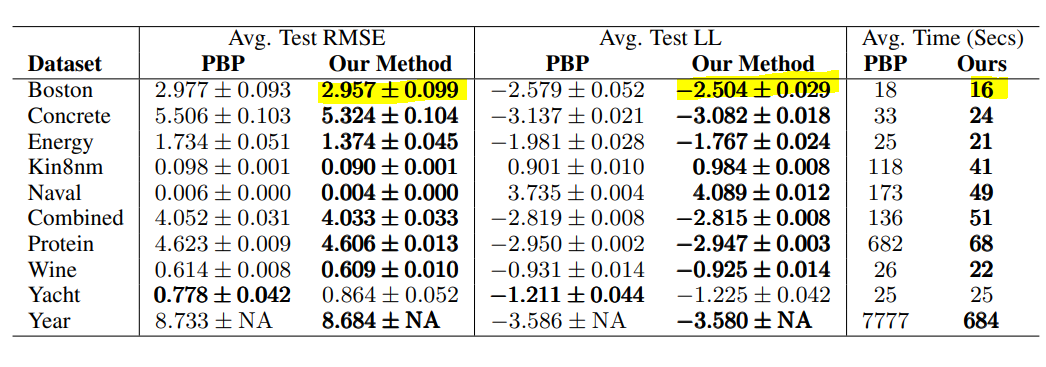

## A new experiment


In [21]:
class BayesianLR:
    def __init__(self, X, Y, batchsize=100, a0=1, b0=0.01):
        self.X, self.Y = X, Y
        # TODO. Y in \in{+1, -1}
        self.batchsize = min(batchsize, X.shape[0])
        self.a0, self.b0 = a0, b0
        
        self.N = X.shape[0]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0
    
        
    def dlnprob(self, theta):
        
        if self.batchsize > 0:
            batch = [ i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize) ]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])
            
        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]
        
        w = theta[:, :-1]  # logistic weights
        alpha = np.exp(theta[:, -1])  # the last column is logalpha
        d = w.shape[1]
        
        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))
        
        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))
        
        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d) , w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale
        
        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term
        
        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative 
    
    def evaluation(self, theta, X_test, y_test):
        theta = theta[:, :-1]
        M, n_test = theta.shape[0], len(y_test)

        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = np.divide(np.ones(n_test), (1 + np.exp(coff)))
        
        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        llh = np.mean(np.log(prob))
        return [acc, llh]


In [34]:
import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm

In [38]:
data = scipy.io.loadmat('./Stein-Variational-Gradient-Descent/data/covertype.mat')

X_input = data['covtype'][:, 1:]
y_input = data['covtype'][:, 0]
y_input[y_input == 2] = -1

N = X_input.shape[0]
X_input = np.hstack([X_input, np.ones([N, 1])])
d = X_input.shape[1]
D = d + 1

# split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

a0, b0 = 2, 0.01 #hyper-parameters
model = BayesianLR(X_train, y_train, 100, a0, b0) # batchsize = 100

# initialization
M = 100  # number of particles
theta0 = np.zeros([M, D]);
alpha0 = np.random.gamma(a0, b0, M); 
for i in range(M):
    theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])

theta = SVGD().update(x0=theta0, lnprob=model.dlnprob, bandwidth=-1, n_iter=6000, stepsize=0.05, alpha=0.9, debug=True)

print ('[accuracy, log-likelihood]')
print (model.evaluation(theta, X_test, y_test))

iter 1000
iter 2000
iter 3000
iter 4000
iter 5000
iter 6000
[accuracy, log-likelihood]
[0.7440599640284674, -0.5259932860156361]


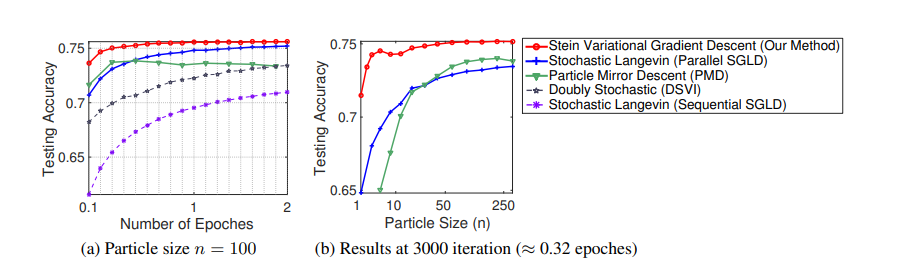

In [39]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)    

In [43]:
A = np.array([[0.2260,0.1652],[0.1652,0.6779]])
mu = np.array([-0.6871,0.8010])

model = MVN(mu, A)

x0 = np.random.normal(0,1, [10,2]);
theta = SVGD().update(x0, model.dlnprob, n_iter=1000, stepsize=0.01)

print ("ground truth: ", mu)
print ("svgd: ", np.mean(theta,axis=0))

ground truth:  [-0.6871  0.801 ]
svgd:  [-0.68369226  0.81271181]
